In [7]:
!pip install tslearn

In [8]:
!pip install iisignature

     |████████████████████████████████| 1.3 MB 17.7 MB/s eta 0:00:01
  Created wheel for iisignature: filename=iisignature-0.24-cp36-cp36m-linux_x86_64.whl size=2523003 sha256=5841b7e98cd1d48d2cd750c19ecbf15f53b94f4f1233f293e7676a4da6e4fb5b
  Stored in directory: /home/azureuser/.cache/pip/wheels/4d/1d/7d/44bbe495b4af0c25baacc704f8b26e5def26268ce749688f0a
Successfully built iisignature


In [2]:
# !git clone 'https://github.com/crispitagorico/Signature-Kernel.git'

# %cd Signature-Kernel/src/ 

# !python setup.py build_ext --inplace

In [4]:
%cd Signature-Kernel/notebooks/

/mnt/batch/tasks/shared/LS_root/mounts/clusters/nc6-k80-6-56-cs/code/Users/csalvi/Signature-Kernel/notebooks


In [23]:
import base

import numpy as np
from tqdm import notebook as tqdm
import matplotlib.pyplot as plt
import torch 

import iisignature

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from tslearn.datasets import UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from tslearn.svm import TimeSeriesSVC

from transformers_sig import AddTime, LeadLag

from sigKer_fast import sig_kernel_Gram_matrix 
from sigKer_torch import SigKernelGramMat

In [11]:
def transform(paths, scale=1., at=False, ll=False):
    if ll:
        paths = LeadLag().fit_transform(paths)
    if at:
        paths = AddTime().fit_transform(paths)
    return scale*np.array(paths)

In [12]:
data = UCR_UEA_datasets().list_multivariate_datasets()

data_dic = {11:'FingerMovements', 14:'Heartbeat', 22:'PEMS-SF'}

name = data_dic[11]

In [13]:
X_train, Y_train, X_test, Y_test = UCR_UEA_datasets(use_cache=True).load_dataset(name)

In [31]:
subsample = 1
x_train = X_train[::subsample]
y_train = Y_train[::subsample]
x_test = X_test[::subsample]
y_test = Y_test[::subsample]

x_train = TimeSeriesScalerMinMax().fit_transform(x_train)
x_test = TimeSeriesScalerMinMax().fit_transform(x_test)

print(x_train.shape)
print(x_test.shape)

(316, 50, 28)
(100, 50, 28)


In [32]:
scale = 1.
at = False
ll = False

In [33]:
x_train = transform(x_train, scale, at, ll)
x_test = transform(x_test, scale, at, ll)

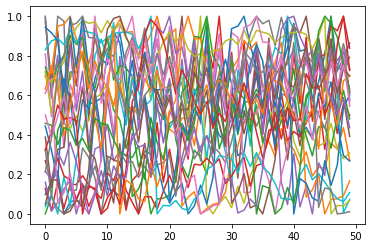

In [34]:
plt.plot(x_train[0])
plt.show()

In [35]:
print(f'classes: {np.unique(y_train)}')

classes: ['left' 'right']


In [36]:
n, solver =  0, 1

In [37]:
x_train_ = torch.tensor(x_train).cuda()
x_test_ = torch.tensor(x_test).cuda()

In [38]:
# gram_matrix = sig_kernel_Gram_matrix(x_train, x_train, n, solver, sym=True)
gram_matrix_ = SigKernelGramMat.apply(x_train_, x_train_, n, solver, True)

In [39]:
# test_matrix = sig_kernel_Gram_matrix(x_train, x_test, n, solver, sym=False)
test_matrix_ = SigKernelGramMat.apply(x_train_, x_test_, n, solver, False)

In [40]:
gram_matrix = gram_matrix_.cpu().numpy()
test_matrix = test_matrix_.cpu().numpy()

In [41]:
svc_parameters = {'C': np.logspace(0, 4, 5), 'gamma': np.logspace(-2, 2, 5)}

In [42]:
svc = TimeSeriesSVC(kernel='precomputed', decision_function_shape='ovo')

svc_model = GridSearchCV(estimator=svc, 
                         param_grid=svc_parameters, 
                         cv=TimeSeriesSplit(n_splits=5),
                         n_jobs=-1)

In [43]:
svc_model.fit(gram_matrix, y_train)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  category=UserWarning


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=TimeSeriesSVC(decision_function_shape='ovo',
                                     kernel='precomputed'),
             n_jobs=-1,
             param_grid={'C': array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
                         'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])})

In [44]:
predictions = svc_model.predict(test_matrix.T)

In [45]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

        left       0.08      0.44      0.14         9
       right       0.90      0.51      0.65        91

    accuracy                           0.50       100
   macro avg       0.49      0.47      0.39       100
weighted avg       0.83      0.50      0.60       100



In [46]:
final = {}

In [ ]:
for ker in ['linear', 'rbf', 'gak']:
    
    svc = TimeSeriesSVC(kernel=ker, decision_function_shape='ovo')

    svc_model = GridSearchCV(estimator=svc, 
                             param_grid=svc_parameters, 
                             cv=TimeSeriesSplit(n_splits=5),
                             n_jobs=-1)
    
    svc_model.fit(x_train, y_train)
    
    final[ker] = svc_model.score(x_test, y_test)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


In [ ]:
# truncated signature kernel
for d in tqdm.tqdm(range(1,2)):
    
    svc = TimeSeriesSVC(kernel='linear', decision_function_shape='ovo')

    svc_model = GridSearchCV(estimator=svc, 
                             param_grid=svc_parameters, 
                             cv=TimeSeriesSplit(n_splits=5),
                             n_jobs=-1)

    sig_train = [iisignature.sig(path, d) for path in x_train]
    sig_test = [iisignature.sig(path, d) for path in x_test]

    svc_model.fit(sig_train, y_train)

    final[f'sig-ker-{d}'] = svc_model.score(sig_test, y_test)

In [384]:
final['sig-ker-PDE'] = svc_model.score(test_matrix.T, y_test)

In [385]:
final_csv = pd.DataFrame.from_dict(final, orient='index').rename(columns={0:'accuracy (%)'})
print(final_csv)
final_csv.to_csv(f'../results/svm-{name}-{np.round(scale,3)}.csv')

             accuracy (%)
linear           0.916667
poly-2           0.283333
poly-3           0.233333
poly-4           0.233333
rbf              0.916667
sig-naive-1      0.633333
sig-naive-2      0.783333
sig-naive-3      0.816667
sig-naive-4      0.833333
sig-PDE          0.883333
